Modeling in Theory: State probability density

An approach to estimate volatilities on past data is used. Rosenberg and Engle (2002)
propose a contemporaneous forecast of the one-month S&P500 return density. To estimate the forecast
probability density, Rosenberg and Engle (2002) use a stochastic volatility model. An asymmetric
GARCH model to specify the equity index return process based on Rosenberg and Engle (2002) is used. 
The model contains an innovation density 𝜀, consisting of a time-variant and a time-invariant part. The time-invariant part, the standardized innovation, is a normal distribution. The time-variant part is a conditional standard deviation. The asymmetric GARCH used in the estimation process is defined as:

(GARCH FORMULA)

while:

(RETURN SPECIFICATION)

We derive a volatility and a mean forecast with the asymmetric GARCH model. The asymmetric GARCH model used
is also known as GJR GARCH, first introduced by Glosten, Jagannathan, and Runkle (1993). Glosten,
Jagannathan, and Runkle (1993) explain how the GJR GARCH allows for taking into account volatility
clustering with seasonal patterns, while positive or negative innovations can have different impacts on the
conditional volatility.

For the GARCH estimation, a Python library that facilitates the process is used. The model in the
package allows to apply the GJR GARCH, and thereby estimate the variance based on past returns. A
disadvantage to the model is that it does not work accurately with very small returns. A scaling of 100x is
applied on the returns (!). Mathematically, the estimated variance then has to be divided by 10’000 to rescale it
to the proper value, before taking the root in order to retrieve the volatility. The model is then fitted based on past returns between start and end date.

We then go on to specifically estimate and forecast the returns, and therefore the probability densities of
the next time-period. This procedure is then repeated X times (the more repetitions, the more accurate the probability forecast) with a Monte Carlo simulation to get the monthly returns.

The forecast probability density as explained by Rosenberg and Engle (2002) can be defined as f(rt+1),
where 𝑟t refers to the one-period return (St+1/St). Specifically, Rosenberg and Engle (2002) estimate the
monthly return by forecasting 20 states per month. This is based on the assumption that a month is
represented by 20 business days, so we continue to do the same. (If we consider crypto, we should go with 30 days since it trades daily). The conditional standard deviation and the mean estimated by the initial
fit of the GJR GARCH model provide the sigma (𝜎|t-1), the time-varying component of the empirical
innovation density, and the mu (𝜇). The epsilon, a random normal distribution with 𝜇 = 0 and 𝜎 = 1, gets
multiplied with sigma to account for that. Each state, is therefore defined by 𝑒**(𝜇+epsilon*𝜎). The simple return of that very state is then simply retrieved as 𝑒**(𝜇+epsilon*𝜎) − 1. Using the GJR GARCH, the simulated simple return (𝑟t+1), together with the past time series of returns, is then used to update the conditional volatility as (𝜎|t+2). Once twenty (or thirty depending on the asset) volatilities, and with them twenty states, are estimated, a full month is simulated. The monthly return is then approximated with (𝑆t+20/ 𝑆t − 1). This process is repeated X times in order to retrieve the one-month return distribution density.

This finally gives us our probability distribution for a certain return in the next period. So each return in t+1 (next month) is now happening with a certain probability that we can retrieve from the distribution.

These returns are then plotted, and a smoothing process is applied to display the distribution. To plot the probability density with a Gaussian kernel density, Rosenberg and Engle (2002) make use of Silverman’s rule of thumb (Silverman (1986)) and choose the following bandwidth to smooth the distribution.

(BANDWIDTH)


Our goal is now to code an API to import any asset return history that we want and to retrieve from that the distribution forecast.

Import packages | We do not need all of them but that's what I used

In [1]:
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning) #we want to not print any warnings
import numpy as np
import pandas as pd
from math import sqrt
from pandas_datareader import data as web
import matplotlib.pyplot as plt
import matplotlib.ticker as mtick
from arch import arch_model
from sklearn.neighbors import KernelDensity
from tqdm import tqdm
import yfinance as yf

Load Data | here an API will serve us as source (Binance?)
The Interface will be built through "Streamlit"

In [2]:
def data_feeder(ticker, start_date, end_date, n):

    # Get the data
    df = yf.download(ticker, start_date, end_date)

    #turn Closing into log return and scale it with 100
    df['Return'] = 100 * np.log(df['Close']).diff()

    #drop empty rows in case there are any
    df = df.dropna()

    returns = df['Return']

    return returns

In [3]:
#We compute the first GARCH model:

def garch(returns):
    
    # feed in data until date
    gjr_gm = arch_model(returns, p = 1, q = 1, o = 1, vol = 'GARCH', dist = 't', rescale=False)

    # Fit the model
    gjrgm_result = gjr_gm.fit(update_freq=1, disp = 'off')

    # Forecast volatilities 1-20 for Working days (1 month)
    gjr_forecast = gjrgm_result.forecast(horizon = 1)

    #these are the initial inputs for every simulation cycle
    sigma = sqrt(gjr_forecast.variance["h.1"].iloc[-1] / 10000)#rescale with 10000, that's the factor for std to return
    mu = gjr_forecast.mean["h.1"].iloc[-1]

    return_list = returns.to_numpy() #turn the pd column into an array

    #PLOT GARCH VOL
    ###############

    vol = sqrt(250)*gjrgm_result.conditional_volatility #annualized list of vols to plot

    fig, ax = plt.subplots(figsize=(15, 5))

    # Plot GJR-GARCH estimated volatility | only cosmetics for plit
    ax.plot(vol, color = 'black', label = 'GJR-GARCH Volatility')
    ax.yaxis.set_major_formatter(mtick.PercentFormatter())

    ax.set_xlabel('Date')
    ax.set_ylabel(ticker + ' Return Volatility')
    ax.set_title("Asymmetric GARCH model from " + start_date +  " until " + end_date)

    ax.legend(loc="lower center",bbox_to_anchor=(0.5, -0.25))

    plt.show()

    return sigma, mu, return_list

Now we start the Monte Carlo simulation to forecast our returns. 

In [4]:
#Return Monte Carlo Simulation
#############################

def monte_carlo_simulation(return_list, mu, sigma):
    monthly_return_list=[]

    for i in tqdm(range(n)):

        #open the list to append all the values from one iteration
        states=[]

        for j in range(30): #we need to forecast 30 days with crypto
            
            #one day innovation
            epsilon = np.random.normal(0, 1) #random number
            
            # Determine States 1-30
            state = np.exp(mu + epsilon*sigma) #time varying sigma multiplied with innvoation for state
            states.append(state) #pack elements into states list       
            state_return = (state-1) * 100 #upscale to plug it back in 
            return_list = np.append(return_list, np.array([state_return]), axis=0)

            #apply the GARCH again, this simulates the next sigma based on all the past returns including the one estimated above
            gjr_gm = arch_model(return_list, p = 1, q = 1, o = 1, vol = 'GARCH', dist = 't', rescale=False)
            gjrgm_result = gjr_gm.fit(update_freq=1, disp = 'off', show_warning=False)
            gjr_forecast = gjrgm_result.forecast(horizon = 1)
            sigma_ = sqrt(gjr_forecast.variance["h.1"].iloc[-1] / 10000) #rescale

        monthly_return = states[-1]/states[0]-1 # compute monthly return
        monthly_return_list.append(monthly_return) #append to our final list of returns

    df = np.asarray(monthly_return_list)#turn list into array
    df = df[np.isfinite(df)] #remove inf and nan, should not happen though
    average_percent = str(round(100 * np.mean(df), 2))

    print ("The on average forecasted return of " + ticker + " over the next month is " + average_percent +"%")
    return df

In [5]:
#We now plot our returns applying a kernel density | It's up to us how we do that
##################################################

def density_plot(df):

    returns = df.reshape(-1, 1) #we need to turn the list into a 2D array to plot them

    X_plot = np.linspace(-.2, .2, 1000)[:, np.newaxis]
    bins = np.linspace(-.2, .2, 50)

    std = np.std(returns)

    bandwidth = 0.9 * n**(-1/5) * std #get the bandwidth #n is defined on top and is the nr of repetitions

    kde = KernelDensity(kernel='gaussian', bandwidth=bandwidth).fit(returns) #fit the kernel
    kde_score_samples=kde.score_samples(X_plot)

    fig, ax = plt.subplots(1, 2, figsize=(15, 5), sharex=True, sharey=False)
    fig.subplots_adjust(hspace=0.1, wspace=0.1)

    ax[0].hist(returns[:, 0],bins=bins, color = "black", label = "return distribution")
    ax[1].plot(X_plot[:, 0],np.exp(kde_score_samples), color = "black",label = "smoothed distribution")

    ax[0].set_xlabel(ticker + " next period return")
    ax[0].set_ylabel('Returns per Bin')
    ax[0].set_title("Return Density Historgram")

    ax[1].set_xlabel(ticker + " next period return")
    ax[1].set_ylabel('Probability Density')
    ax[1].set_title("Return Density Function")

    ax[0].legend(loc="lower center",bbox_to_anchor=(0.5, -0.3))
    ax[1].legend(loc="lower center",bbox_to_anchor=(0.5, -0.3))

    plt.show()

[*********************100%***********************]  1 of 1 completed


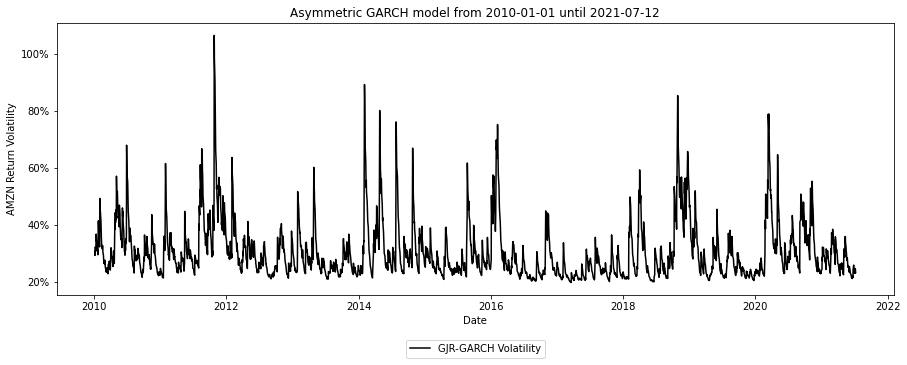

100%|██████████| 3/3 [00:09<00:00,  3.11s/it]


The on average forecasted return of AMZN over the next month is 0.67%


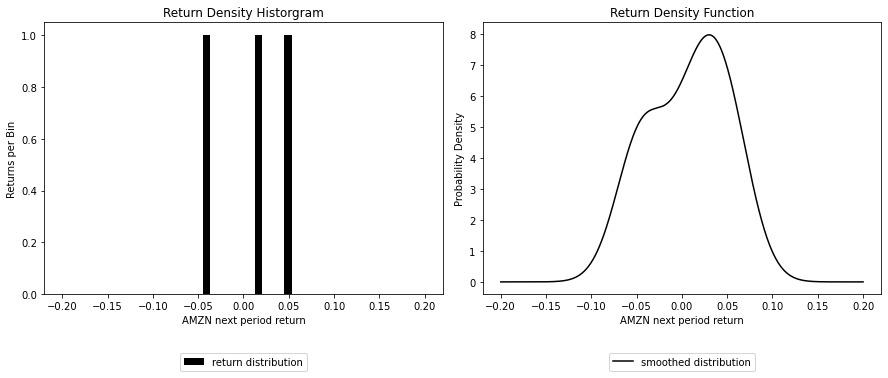

In [6]:
# Set the start and end date
start_date = '2010-01-01'
end_date = '2021-07-12'

# Set the ticker
ticker = 'AMZN'

# Set the number of simulated return
n = 3

returns = data_feeder(ticker, start_date, end_date, n)

sigma, mu, return_list = garch(returns)

df = monte_carlo_simulation(return_list, mu, sigma)

density_plot(df)